In [141]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from random import choice
import pickle
from string import ascii_uppercase
import dataframe_image as dfi

#draft class

In [142]:
class ProcessData:
    def __init__(self, data_path = 'wine_data.csv', input_df = None) -> None:
        # print("Dataframe: ", type(input_df))
        if type(input_df) == pd.core.frame.DataFrame:
            self.df = input_df
        else:
            self.df = pd.read_csv(data_path)
            draw_df = self.df.head(15)
            dfi.export(draw_df.style.set_table_styles(), "dfImage.png", table_conversion="matplotlib", use_mathjax=False)

        self.df_arr = self.df.to_numpy()
        self.cols = list(self.df.columns)
        self.standardized_df = []
    
    # STANDARDIZE DATASET SUCH THAT MEAN WILL BE 0 AND STANDARD DEVIATION BE 1
    def standadardize_data(self):
        data_with_mean_0 = self.df_arr - self.df_arr.mean()
        data_with_std_1 = data_with_mean_0 / self.df_arr.std()
        standardized_data = data_with_std_1
        self.standardized_df = pd.DataFrame(standardized_data, columns = self.cols)

        # mean of each feature
        each_feature_mean = self.standardized_df.mean()
        for index, col in enumerate(self.cols):
            self.standardized_df[col] -= each_feature_mean[index]
        return self.standardized_df
        
    def compute_covariance_matrix(self, standardized_data):
        multiplied = pd.DataFrame()
        for col in self.cols:
            for j, COL in enumerate(self.cols):
                if j != len(self.cols):
                    multiplied[col + " " + self.cols[j]] = standardized_data[col] * standardized_data[self.cols[j]]
        
        sums = multiplied.sum()
        c = [i for i in range(0, len(sums), 13)]

        Covariance_matrix = []
        for i, index in enumerate(c):
            try:
                Covariance_matrix.append(list(sums[index:c[i+1]]))
            except IndexError: 
                Covariance_matrix.append(list(sums[index:]))

        covariance_df = pd.DataFrame(Covariance_matrix, columns=self.cols, index = self.cols)
        cov_matrix = np.array(Covariance_matrix)
        return cov_matrix
    
    def Compute_principal_components(self, cov_matrix):
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigenvalues_eugenvectors = {eigenvalue:eigenvectors[index] for index, eigenvalue in enumerate(eigenvalues)}
        eigenvalues.sort()
        
        # CHOOSE ONLY TOP 3 MAXIMUM EIGENVALUES AND GET THEIR EIGENVECTORS
        max_3_eigenvectors = eigenvalues[::-1][:3]
        eigenvectors_of_top_3_eigenvalues = np.array([eigenvalues_eugenvectors[eigen] for eigen in max_3_eigenvectors])

        eigenvectors_of_top_3_eigenvalues = np.transpose(eigenvectors_of_top_3_eigenvalues)
        reduced_dimension_wine_dataset = np.dot(self.df_arr, eigenvectors_of_top_3_eigenvalues)
        pc_df = pd.DataFrame(reduced_dimension_wine_dataset, 
                            columns = ['Principal comp1', 'Principal comp2', 'Principal comp3'])
        # p = pc_df
        dfi.export(pca_df.head(15).style.set_table_styles(), "pca.png", table_conversion="matplotlib")
        return reduced_dimension_wine_dataset, pd.DataFrame(reduced_dimension_wine_dataset, 
                                                            columns = ['Principal comp1', 'Principal comp2', 'Principal comp3'])
  

class Clustering:
    def __init__(self, dataframe, principal_components_array) -> None:
        # clusters = 2
        self.df = dataframe
        self.clusters_data = [[],[]]
        self.centroids = [[],[]]
        self.k1_initial_centroids = [choice(self.df[col]) for col in list(self.df.columns)]
        self.k2_initial_centroids = [choice(self.df[col]) for col in list(self.df.columns)]
        self.pca_array = principal_components_array

    def __Generate_clusters_phase1(self, k1_mean, k2_mean):
        # FIRST CLEAR THE CLUSTERS TO PREPARE THEM FOR RECEIVING NEW DATA
        self.clusters_data[0].clear()
        self.clusters_data[1].clear()
        
        # COMPUTE THE EUCLEDIAN DISTANCES
        variance1 = (self.pca_array - np.array(k1_mean)) ** 2
        variance2 = (self.pca_array - np.array(k2_mean)) ** 2
        eucledian_distances1 = np.sqrt(np.array([sum(row) for row in variance1]))
        eucledian_distances2 = np.sqrt(np.array([sum(row) for row in variance2]))
        combined = zip(eucledian_distances1, eucledian_distances2)

        for index, j in enumerate(combined):
            # CLASSIFY THE DATA INTO ITS CLUSTER BASED ON THE ONE WITH THE SMALLEST EUCLIDEAN DISTANCE
            self.clusters_data[j.index(min(j))].append(list(self.pca_array[index]))
            
        self.centroids[0].append(np.mean(np.array(self.clusters_data[0]), axis = 0))
        self.centroids[1].append(np.mean(np.array(self.clusters_data[1]), axis = 0))
        # return k1_mean, k2_mean
    
    def Optimize_clusters(self, epochs = 10):
        for i in range(epochs):
            if len(self.centroids[0]) > 0 and len(self.centroids[1]) > 0:
                self.__Generate_clusters_phase1(k1_mean=self.centroids[0][-1], k2_mean=self.centroids[1][-1])
                # THRESHOLD TO STOP ITERATION WHEN OPTIMAL CLUSTERS ARE OBTAINED
                if sum(self.centroids[0][-2]) - sum(self.centroids[0][-1]) <= 0.01 and sum(self.centroids[0][-2]) - sum(self.centroids[0][-1]) <= 0.01:
                    print(f"OPTIMAL CENTROID ACHIEVED AT {i+1}/{epochs} EPOCH")
                    print(f"OPTIMAL CENTROIDS: [CLUSTER 1] {self.centroids[0][-1]}")
                    print(f"OPTIMAL CENTROIDS: [CLUSTER 2] {self.centroids[1][-1]}")
                    break
            else:
                self.__Generate_clusters_phase1(k1_mean = self.k1_initial_centroids, k2_mean = self.k2_initial_centroids)

        # SAVE OPTIMAL CENTROID OF BOTH CLUSTERS
        with open('optimal_centroids.pkl', 'wb') as f:
            pickle.dump([self.centroids[0][-1], self.centroids[1][-1]], f)
        # print("OPTIMAL CENTROIDS ARE SAVED FOR FUTURE PREDICTIONS")
        return self.clusters_data

    def Predict(self, new_data):
        # LOAD CLUSTERS CENTROIDS
        with open('optimal_centroids.pkl', 'rb') as f:
            k1_centroid, k2_centroid = pickle.load(f)
        # PROCESS INPUT DATA
        cols = [letter for letter in ascii_uppercase][0:len(new_data)]
        new_data_df = pd.DataFrame([new_data], columns=cols)
        # print("New data frame")
        # print(new_data_df)
        data_cleaning = ProcessData(input_df=new_data_df)
        standard_data = data_cleaning.standadardize_data()
        cov_matrix = data_cleaning.compute_covariance_matrix(standardized_data=standard_data)
        principal_comps, pca_df = data_cleaning.Compute_principal_components(cov_matrix=cov_matrix)

        # DECIDE CLUSTER
        variance1 = (principal_comps - np.array(k1_centroid)) ** 2
        variance2 = (principal_comps - np.array(k2_centroid)) ** 2
        eucledian_distances1 = np.sqrt(np.array([sum(row) for row in variance1]))
        eucledian_distances2 = np.sqrt(np.array([sum(row) for row in variance2]))
        # print('LIST: ', [list(eucledian_distances1)[0], list(eucledian_distances2)[0]])
        distances = [list(eucledian_distances1)[0], list(eucledian_distances2)[0]]
        decision = ['CLUSTER 1', 'CLUSTER 2'][distances.index([min([list(eucledian_distances1)[0], list(eucledian_distances2)[0]])])]
        print(f"{new_data} is in [{decision}]")


class Plotting_clusters:
    def __init__(self, clusters, plot_clusters = True, color1 = 'red', color2 = 'green'):
        fig = plt.figure(figsize=(8, 10))
        self.ax = fig.add_subplot(111, projection = '3d')
        if plot_clusters:
            self.x_cluster1, self.y_cluster1, self.z_cluster1 = zip(*clusters[0])
            self.x_cluster2, self.y_cluster2, self.z_cluster2 = zip(*clusters[1])
            
            self.ax.scatter(self.x_cluster1, self.y_cluster1, self.z_cluster1, color = color1,
                             label = 'cluster 1', s = 40)
            self.ax.scatter(self.x_cluster2, self.y_cluster2, self.z_cluster2, color = color2, 
                            label = 'cluster 2', s=40)
            with open('optimal_centroids.pkl', 'rb') as f:
                k1_centroid, k2_centroid = pickle.load(f)
                x1, y1, z1 = k1_centroid
                x2, y2, z2 = k2_centroid
                self.ax.scatter(x1, y1, z1, color = 'yellow', marker='*', s=60)
                self.ax.scatter(x2, y2, z2, color = 'yellow', marker='*', s=60)
            self.ax.set_xlabel('PC 1')
            self.ax.set_ylabel('PC 2')
            self.ax.set_zlabel('PC 3')
            plt.title('After applying Unsupervised machine learning (K-means clustering)')
            plt.legend()
        else:
            pca_cols = list(clusters.columns)
            # self.ax = fig.add_subplot(111)
            self.x_cluster1, self.y_cluster1, self.z_cluster1 = (clusters[pca_cols[0]], clusters[pca_cols[1]], clusters[pca_cols[2]])
            self.ax.scatter(self.x_cluster1, self.y_cluster1,self.z_cluster1, color = 'gray', label = 'PC1 ~ PC2')
            # self.ax.scatter(self.x_cluster1, self.z_cluster1, color = 'maroon', label = 'PC1 ~ PC3')
            self.ax.set_xlabel('PC 1')
            self.ax.set_ylabel('PC 2')
            self.ax.set_zlabel('PC 3')
            
            plt.title('Before applying K-means clustering algorithm')
            plt.legend()

        # Display the plot
        plt.show()
        

C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.standardized_df[col] -= each_feature_mean[index]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiplied[col + " " + self.cols[j]] = standardized_data[col] * standardized_data[self.cols[j]]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

OPTIMAL CENTROID ACHIEVED AT 2/10 EPOCH
OPTIMAL CENTROIDS: [CLUSTER 1] [  4.37317618 -68.14263826 -44.94735882]
OPTIMAL CENTROIDS: [CLUSTER 2] [  3.83937748 -86.43118145 -95.52367133]


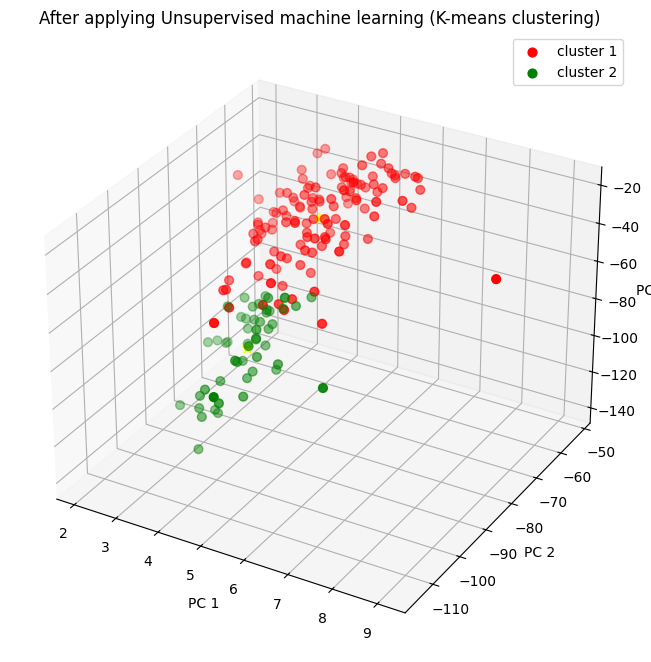

C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.standardized_df[col] -= each_feature_mean[index]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiplied[col + " " + self.cols[j]] = standardized_data[col] * standardized_data[self.cols[j]]
C:\Users\PROBOOK\AppData\Local\Temp\ipykernel_1508\2965421001.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

[0.3, 1.5, 2.7, 22.5, 101, 3, 3.25, 0.29, 2.38, 5.7, 1.19, 2.71, 1285] is in [CLUSTER 1]


In [143]:
data_cleaning = ProcessData()
standard_data = data_cleaning.standadardize_data()
cov_matrix = data_cleaning.compute_covariance_matrix(standardized_data=standard_data)
principal_comps, pca_df = data_cleaning.Compute_principal_components(cov_matrix=cov_matrix)

classifier = Clustering(dataframe=pca_df, principal_components_array=principal_comps)
clusters = classifier.Optimize_clusters()
# print(clusters)
# plot_before_clustering = Plotting_clusters(clusters = pca_df, plot_clusters=False)
plotter = Plotting_clusters(clusters = clusters)

classifier.Predict([0.3,1.5,2.7,22.5,101,3,3.25,0.29,2.38,5.7,1.19,2.71,1285])
# Plotting_clusters(clusters = principal_comps)
